In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tqdm import tqdm
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageOps
import os
from keras.callbacks import Callback, ModelCheckpoint
from keras.applications import DenseNet121
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [3]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

def augmentate_image(im, desired_size=224):
    imageArray = []
    data = img_to_array(im)
    samples = expand_dims(data, 0)
    
    datagen = ImageDataGenerator(brightness_range=[0.8,1.8])
    it = datagen.flow(samples, batch_size=1)

    for i in range(9):
        batch = it.next()
        image = np.uint8(batch[0])
        rimage = np.flip(image, axis=1)
        imageArray.append(image)
        imageArray.append(rimage)

    return imageArray
    

In [4]:
N = train_df.shape[0]
x = np.empty((N, 224, 224,3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x[i, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')

N = test_df.shape[0]
sub = np.empty((N, 224, 224,3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    sub[i, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{image_id}.png')

y = pd.get_dummies(train_df['diagnosis']).values

print(x.shape)
print(y.shape)
print(sub.shape)

100%|██████████| 1928/1928 [01:39<00:00, 15.47it/s]

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [5]:
y_train_multi = np.empty(y.shape, dtype=y.dtype)
y_train_multi[:, 4] = y[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y[:, i], y_train_multi[:, i+1])

print("Original y_train:", y.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [6]:
print(y)
BATCHSIZE = 32
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.15, 
    random_state=2019
)


[[0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 ...
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]


In [7]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train,seed=2019)

In [8]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [9]:
class_weight = {
    0:1,
    1:4.88,
    2:1.81,
    3:9.35,
    4:6.12
}

densenet = DenseNet121(
    weights='../input/densenet/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [10]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [11]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [12]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0]/BATCHSIZE,
    epochs=15,
    validation_data=(x_test, y_test),
    callbacks=[kappa_metrics]
)

Epoch 1/15
98/97 [==============================] - 81s 828ms/step - loss: 1.2723 - acc: 0.5733 - val_loss: 0.6339 - val_acc: 0.8109
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 2/15
98/97 [==============================] - 38s 387ms/step - loss: 0.7698 - acc: 0.7318 - val_loss: 0.5417 - val_acc: 0.8218
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 3/15
98/97 [==============================] - 38s 385ms/step - loss: 0.6428 - acc: 0.7752 - val_loss: 0.4605 - val_acc: 0.8327
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 4/15
98/97 [==============================] - 38s 385ms/step - loss: 0.5983 - acc: 0.7848 - val_loss: 0.4450 - val_acc: 0.8345
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 5/15
98/97 [==============================] - 37s 379ms/step - loss: 0.5331 - acc: 0.8039 - val_loss: 0.4345 - val_acc: 0.8382
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 6/15
98/97 [==

In [13]:
score = model.evaluate(x_test,y_test, verbose = 0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.86


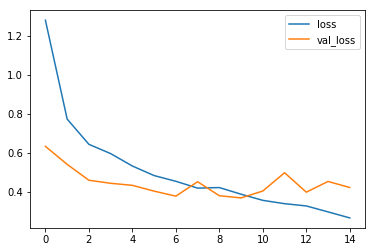

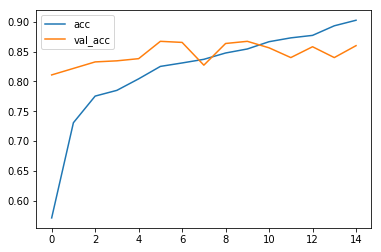

In [14]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

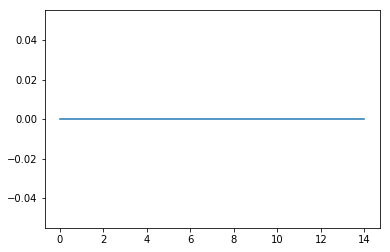

In [15]:
plt.plot(kappa_metrics.val_kappas)

In [16]:
predictions = model.predict(sub) 
print(predictions)
final = np.argmax(predictions, axis = 1)
print(final)
submission = pd.DataFrame(data={'id_code': test_df['id_code'], 'diagnosis': final})
print(submission.head())
submission.to_csv('submission.csv', index=False)

[[2.20005661e-02 6.50344968e-01 3.05294275e-01 6.56589307e-03
  1.57942753e-02]
 [2.49606401e-05 1.52731279e-03 2.31134921e-01 6.25942111e-01
  1.41370669e-01]
 [7.36213187e-05 9.15239304e-02 4.80502129e-01 4.17464316e-01
  1.04359686e-02]
 ...
 [1.78307948e-06 9.96591756e-04 7.43954957e-01 2.51367033e-01
  3.67959472e-03]
 [1.19630736e-03 1.20623931e-02 5.30161262e-01 1.56104222e-01
  3.00475776e-01]
 [9.77478504e-01 2.07343255e-04 8.14442988e-03 7.94524385e-05
  1.40903825e-02]]
[1 3 2 ... 2 2 0]
        id_code  diagnosis
0  0005cfc8afb6          1
1  003f0afdcd15          3
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          2
